In [2]:
import pandas as pd
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

import xgboost as xgb

from ga import GeneticAlgorithm

In [3]:
sns.set_style('darkgrid')

## Milestone 2

In the last milestone, I implemented a genetic algorithm that could be used to search non-convex spaces for global maximia/minima and the respective parameters. The genetic algorithm is a useful tool in application when we need to find optimal solutions in spaces that are not well-defined or are high dimensional such that gradient-based numerical solutions are unable to locate global optimums. In materials science, an application of this tool is finding optimal mix configurations to produce high performing concrete. That is, we want to find the parameter set of concrete components that produces a mix with a maximum concrete compressive strength. Using data from Yeh, I-Cheng (1998), we can model the feature space using machine learning and run the genetic algorithm to find the optimal concrete configuration.

In this milestone, I use XGBoost and use the GA to output the predicted highest performing feature set. XGBoost is a gradient boosted tree method known for its speed and performance on tabular data. It seems a good chocie for thsi problem, 

Data courtesy of I-Cheng Yeh, "Modeling of strength of high performance concrete using artificial neural networks," Cement and Concrete Research, Vol. 28, No. 12, pp. 1797-1808 (1998). The data includes 1030 instances measuring the compressive strength measurement of concrete given 8 configuration parameters shown below. The data was posted on UCI's data repository: https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength.

According to the author, many non-linear relationships underly the concrete compressive strength measurement that results from a composition of its 8 constituents. This made the dataset an attractive application for the genetic algorithm (GA). We can first design a machine learning model that captures these complexities, and then use the GA to predict the composition that will create an optimally performing, strong concrete mix.

In [16]:
df = pd.read_excel('concrete.xls')
df.describe().round(2)

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
count,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00
mean,281.17,73.90,54.19,181.57,6.20,972.92,773.58,45.66,35.82
std,104.51,86.28,64.00,21.36,5.97,77.75,80.18,63.17,16.71
min,102.00,0.00,0.00,121.75,0.00,801.00,594.00,1.00,2.33
25%,192.38,0.00,0.00,164.90,0.00,932.00,730.95,7.00,23.71
50%,272.90,22.00,0.00,185.00,6.35,968.00,779.51,28.00,34.44
75%,350.00,142.95,118.27,192.00,10.16,1029.40,824.00,56.00,46.14
max,540.00,359.40,200.10,247.00,32.20,1145.00,992.60,365.00,82.60


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   float64
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   float64
 7   Age (day)                                              1030 non-null   int64  
 8   Concrete compressive strength(MPa, megapascals)  

Split the data by training paramters and labels, break into training and testing sets.

In [5]:
X, y = df.iloc[:,:-1], df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

First, lets try using the off the shelf model and get cross validation scores to get a baseline performance measure.

In [6]:
'''XGBRegressor(verbosity=0
             , base_score=0.5
             , booster='gbtree'
             , colsample_bylevel=1
             , colsample_bynode=1
             , colsample_bytree=1
             , gamma=0
             , importance_type='gain'
             , learning_rate=0.1
             , max_delta_step=0
             , max_depth=3
             , min_child_weight=1
             , missing=None
             , n_estimators=100
             , n_jobs=1
             , nthread=None
             , objective='reg:linear'
             , random_state=0
             , reg_alpha=0
             , reg_lambda=1
             , scale_pos_weight=1
             , seed=None
             , silent=None
             , subsample=1)'''

xgbr = xgb.XGBRegressor(verbosity=0)

# cross validataion 
scores = cross_val_score(xgbr, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

xgbr.fit(X_train, y_train)

mse = mean_squared_error(y_test, xgbr.predict(X_test))
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

Mean cross-validation score: 0.91
K-fold CV average score: 0.92
MSE: 20.45
RMSE: 4.52


Here I use sklearn's randomized parameter search which uses cross validation testing parmater values in the specified ranges. Once it runs, we can get the training parameters that fit our data best.

In [7]:
param_dist = {'n_estimators': stats.randint(150, 500),
              'learning_rate': stats.uniform(0.01, 0.3),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3]
             }
regress = RandomizedSearchCV(xgbr, param_distributions=param_dist, n_iter=25, error_score=0, verbose=3, n_jobs=-1)

numFolds = 5
folds = KFold(n_splits = numFolds, shuffle = True)
kf_cv_scores = cross_val_score(regress, X_train, y_train, cv=kfold )
regress.fit(X_train, y_train)
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 4/5] END colsample_bytree=0.6128907647899967, learning_rate=0.10259270220990106, max_depth=4, min_child_weight=1, n_estimators=381, subsample=0.5661588537737381;, score=0.923 total time=   0.1s
[CV 1/5] END colsample_bytree=0.5108144535249373, learning_rate=0.2893178685883751, max_depth=3, min_child_weight=3, n_estimators=361, subsample=0.6545434968747608;, score=0.919 total time=   0.1s
[CV 5/5] END colsample_bytree=0.5108144535249373, learning_rate=0.2893178685883751, max_depth=3, min_child_we

[CV 5/5] END colsample_bytree=0.6128907647899967, learning_rate=0.10259270220990106, max_depth=4, min_child_weight=1, n_estimators=381, subsample=0.5661588537737381;, score=0.941 total time=   0.1s
[CV 3/5] END colsample_bytree=0.5108144535249373, learning_rate=0.2893178685883751, max_depth=3, min_child_weight=3, n_estimators=361, subsample=0.6545434968747608;, score=0.905 total time=   0.1s
[CV 3/5] END colsample_bytree=0.5950928892792711, learning_rate=0.24001775729179314, max_depth=8, min_child_weight=2, n_estimators=492, subsample=0.87143666434577;, score=0.926 total time=   0.4s
[CV 2/5] END colsample_bytree=0.8912646329305884, learning_rate=0.2221144192689027, max_depth=8, min_child_weight=1, n_estimators=491, subsample=0.5992181249447543;, score=0.898 total time=   0.5s
[CV 2/5] END colsample_bytree=0.9191304923622433, learning_rate=0.06154131354601591, max_depth=4, min_child_weight=3, n_estimators=167, subsample=0.45370237148673326;, score=0.904 total time=   0.1s
[CV 4/5] END 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 3/5] END colsample_bytree=0.6128907647899967, learning_rate=0.10259270220990106, max_depth=4, min_child_weight=1, n_estimators=381, subsample=0.5661588537737381;, score=0.930 total time=   0.1s
[CV 5/5] END colsample_bytree=0.5828527637697932, learning_rate=0.2930682915750034, max_depth=5, min_child_weight=2, n_estimators=329, subsample=0.5382861027403686;, score=0.928 total time=   0.2s
[CV 5/5] END colsample_bytree=0.5950928892792711, learning_rate=0.24001775729179314, max_depth=8, min_child_weight=2, n_estimators=492, subsample=0.87143666434577;, score=0.927 total time=   0.4s
[CV 5/5] END colsample_bytree=0.8912646329305884, learning_rate=0.2221144192689027, max_depth=8, min_child_weight=1, n_estimators=491, subsample=0.5992181249447543;, score=0.924 total time=   0.4s
[CV 5/5] END colsample_bytree=0.9191304923622433, learning_rate=0.06154131354601591, max_depth=4, min_child_weight=3, n_estimators=167, subsample=0.45

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
K-fold CV average score: 0.94


In [8]:
# best training parameters from randomized search with cross validation
bp = regress.best_params_
bp

{'colsample_bytree': 0.8465548069218283,
 'learning_rate': 0.10240078715075915,
 'max_depth': 7,
 'min_child_weight': 3,
 'n_estimators': 326,
 'subsample': 0.3051884970378706}

Now we train a model on our training set using the optimal training parameters. Below, we can see that the scores are an improvement on the original off-the-shelf model. Ideally, having a model that fits the feature space well to the predicitve output will give an output that realistically models the physical space that we're trying to optimize.

In [ ]:
xgbr_optimal = xgb.XGBRegressor(verbosity=0
                                , colsample_bytree=bp['colsample_bytree']
                                , learning_rate=bp['learning_rate']
                                , max_depth=bp['max_depth']
                                , min_child_weight=bp['min_child_weight']
                                , n_estimators=bp['n_estimators']
                                , subsample=bp['subsample'])

kf_cv_scores = cross_val_score(xgbr_optimal, X, y, cv=kfold)

xgbr_optimal.fit(X_train, y_train)
mse = mean_squared_error(y_test, xgbr_optimal.predict(X_test))

print("Training Score: %.2f" % xgbr_optimal.score(X_train, y_train))
print('K-fold CV average score: %.2f' % np.mean(kf_cv_scores))
print("Testing Score: %.2f" % xgbr_optimal.score(X_test, y_test))
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

The testing scores of this model improve on the Yeh (1998) paper which employed a neural network to predict compressive concrete strength. The average testing score of all of the author's experiments is below.

In [30]:
len(author_scores)

8

In [10]:
author_scores = [0.855, 0.814, 0.895, 0.859, 0.916, 0.908, 0.922, 0.911]
np.mean(author_scores)

0.885

The gradient boosting method allows us to look into the model and see which features were having the most significant effect on the models output. In this case, the age of the mix, amount of water, and the amount of fly ash are the three most important components of the mix.

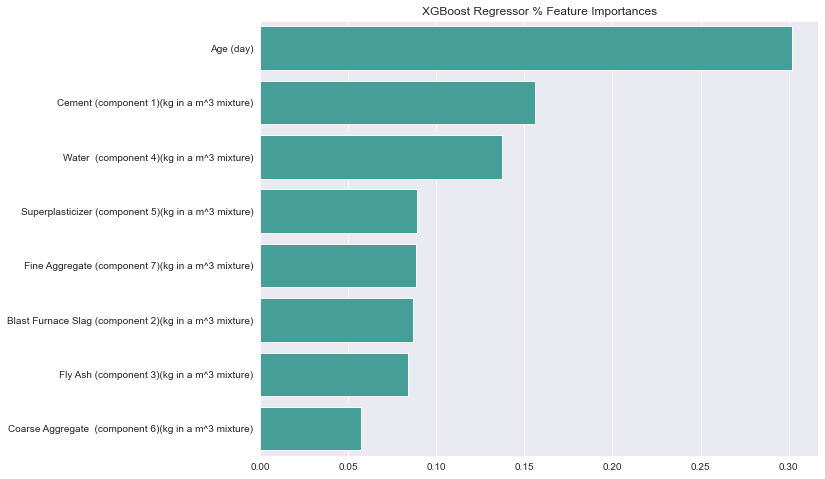

In [11]:
fig, ax = plt.subplots(figsize=(10,8), nrows=1,ncols=1)

ft_importance = xgbr_optimal.feature_importances_
args = ft_importance.argsort()[::-1]
sns.barplot(x=ft_importance[args] , y=df.columns[:-1][args], color=sns.husl_palette(2)[1], orient='h', ax=ax)
ax.set_title('XGBoost Regressor % Feature Importances')

plt.show()

I want to use all the data now to train a model. Normally, we would be weary of doing this because we wouldn't wnat to overfit the mdoel to our data. However, XGBoost regularization should ensure we aren't overfiiting to our data, and we can fill out the search space for the GA as much as possible. Again I will use the optimal training parameters to fit the XGBoost regressor. Using the GA, we can search the regressors' feature space and see which composition of concrete is predicted to be the strongest.

In [12]:
xgbr_ga = xgb.XGBRegressor(verbosity=0
                                , colsample_bytree=bp['colsample_bytree']
                                , learning_rate=bp['learning_rate']
                                , max_depth=bp['max_depth']
                                , min_child_weight=bp['min_child_weight']
                                , n_estimators=bp['n_estimators']
                                , subsample=bp['subsample'])

xgbr_ga.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.8465548069218283, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.10240078715075915,
             max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=3,
             missing=nan, monotone_constraints='()', n_estimators=326, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [13]:
# Keep boundaries within known ranges. This way we can keep the
# interpolations within the known data
boundaries = [[i, j] for i, j in zip(X.min(axis=0), X.max(axis=0))]

In [32]:
ga_concrete = GeneticAlgorithm(model=xgbr_ga
                               , parameters=df.columns[:-1]
                               , boundaries=boundaries
                               , pop_size=100)

strongest_predicted_comp, hist = ga_concrete.run(mode='maximize'
                                                  , select='rank'
                                                  , boltzmann=True
                                                  , generations=2000
                                                  , exploration=.35
                                                  , keep_top=5
                                                  , verbose=False)

According to the GA's search over the XGBoost model, the strongest 

In [34]:
strongest_predicted_comp

{'Cement (component 1)(kg in a m^3 mixture)': 540.0,
 'Blast Furnace Slag (component 2)(kg in a m^3 mixture)': 285.59998167421304,
 'Fly Ash (component 3)(kg in a m^3 mixture)': 123.43754594249728,
 'Water  (component 4)(kg in a m^3 mixture)': 151.11001994539228,
 'Superplasticizer (component 5)(kg in a m^3 mixture)': 11.282155219290692,
 'Coarse Aggregate  (component 6)(kg in a m^3 mixture)': 1029.8330722135322,
 'Fine Aggregate (component 7)(kg in a m^3 mixture)': 749.5383733380505,
 'Age (day)': 150.35350406787876}

In [55]:
list(strongest_predicted_comp.values())

[540.0,
 285.59998167421304,
 123.43754594249728,
 151.11001994539228,
 11.282155219290692,
 1029.8330722135322,
 749.5383733380505,
 150.35350406787876]

In [35]:
# convert dictionary to array suitable for predicition by the GA
comp = np.array(list(strongest_predicted_comp.values())).reshape(1,-1)
predicted_max = xgbr_ga.predict(comp)[0].round(2)
print('Predicited strongest concrete compressive strength:', predicted_max)
print('Is the prediction stronger than the max in our data?', predicted_max >= y.max())

Predicited strongest concrete compressive strength: 107.83
Is the prediction stronger than the max in our data? True


Unlike a neural network or a support vector regression, the XGBoost returns discrete sets of values, so the evolution of its search are happening in steps. We would expect a smoother looking evolution from a function that returns continuous values. 

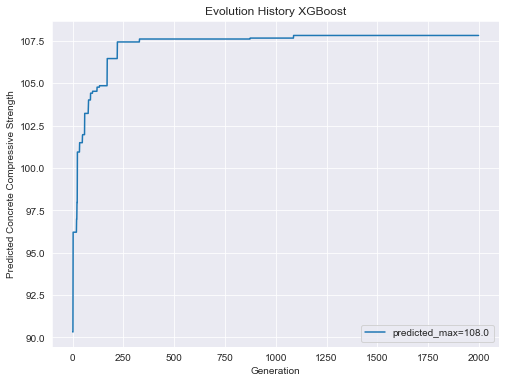

In [36]:
fig, ax = plt.subplots(figsize=(8,6), nrows=1,ncols=1)
sns.lineplot(data=hist, label=f'predicted_max={predicted_max.round()}', ax=ax)
ax.set_xlabel('Generation')
ax.set_ylabel('Predicted Concrete Compressive Strength')
ax.set_title('Evolution History XGBoost')
ax.legend()
plt.show()

In the Yeh (1998) paper, the author trains a neural network with 1 hidden layer with 89 units, a learning rate of 1.0, momentum factor of .5 with 3000 learning cycles. We try a new neural net architecture and a support vector regression to compare.

In [37]:
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

In [38]:
mlp = MLPRegressor(hidden_layer_sizes=(64,128,64,), activation='relu', solver='adam', max_iter=2000)
cv_mlp_score = np.mean(cross_val_score(mlp, X_train, y_train, cv=kfold))
print('K-Fold CV Mean MLP Score:', cv_mlp_score)
mlp.fit(X.values,y.values)

K-Fold CV Mean MLP Score: 0.8020782786418005


MLPRegressor(hidden_layer_sizes=(64, 128, 64), max_iter=2000)

In [40]:
svr = SVR(kernel='poly', degree=8)
cv_svr_score = np.mean(cross_val_score(svr, X_train, y_train, cv=kfold))
print('K-Fold CV Mean SVR Score:', cv_svr_score)
svr.fit(X.values,y.values)

K-Fold CV Mean SVR Score: 0.712453814136116


SVR(degree=8, kernel='poly')

Now we can run the GA on these new models and compare to the XGBoost.

In [41]:
mlp_best, mlp_hist = GeneticAlgorithm(model=mlp, parameters=df.columns[:-1], boundaries=boundaries, pop_size=50).run(mode='maximize', select='rank', boltzmann=True, generations=500, exploration=.35, keep_top=3, verbose=False)

In [42]:
mlp_comp = np.array(list(mlp_best.values())).reshape(1,-1)
predicted_max_mlp = mlp.predict(mlp_comp)[0]

In [43]:
svr_best, svr_hist = GeneticAlgorithm(model=svr, parameters=df.columns[:-1], boundaries=boundaries, pop_size=50).run(mode='maximize', select='rank', boltzmann=True, generations=500, exploration=.35, keep_top=3, verbose=False)

In [44]:
svr_comp = np.array(list(svr_best.values())).reshape(1,-1)
predicted_max_svr = svr.predict(svr_comp)[0]

In [45]:
mlp_best, svr_best

({'Cement (component 1)(kg in a m^3 mixture)': 540.0,
  'Blast Furnace Slag (component 2)(kg in a m^3 mixture)': 284.2139400740389,
  'Fly Ash (component 3)(kg in a m^3 mixture)': 107.49270987529638,
  'Water  (component 4)(kg in a m^3 mixture)': 121.75,
  'Superplasticizer (component 5)(kg in a m^3 mixture)': 32.135500954553244,
  'Coarse Aggregate  (component 6)(kg in a m^3 mixture)': 1145.0,
  'Fine Aggregate (component 7)(kg in a m^3 mixture)': 992.6,
  'Age (day)': 204.6483704300706},
 {'Cement (component 1)(kg in a m^3 mixture)': 540.0,
  'Blast Furnace Slag (component 2)(kg in a m^3 mixture)': 359.4,
  'Fly Ash (component 3)(kg in a m^3 mixture)': 200.1,
  'Water  (component 4)(kg in a m^3 mixture)': 121.75,
  'Superplasticizer (component 5)(kg in a m^3 mixture)': 32.2,
  'Coarse Aggregate  (component 6)(kg in a m^3 mixture)': 1145.0,
  'Fine Aggregate (component 7)(kg in a m^3 mixture)': 992.6,
  'Age (day)': 365.0})

In [46]:
boundaries

[[102.0, 540.0],
 [0.0, 359.4],
 [0.0, 200.1],
 [121.75, 247.0],
 [0.0, 32.2],
 [801.0, 1145.0],
 [594.0, 992.6],
 [1.0, 365.0]]

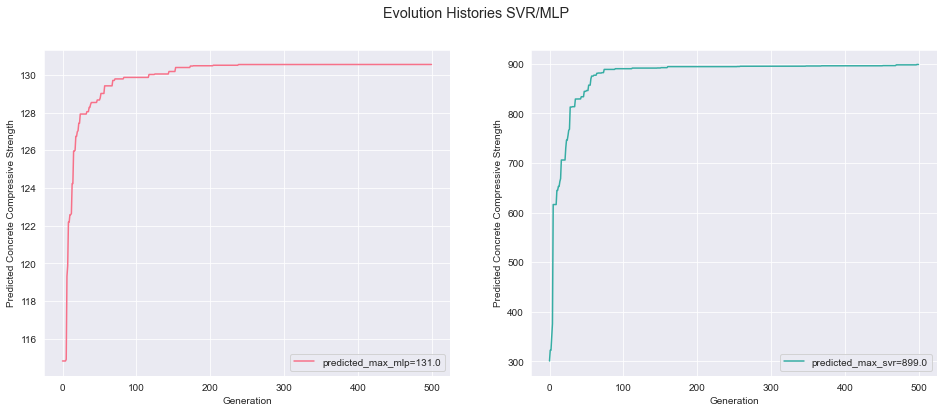

In [47]:
fig, ax = plt.subplots(figsize=(16,6), nrows=1,ncols=2)
sns.lineplot(data=mlp_hist, label=f'predicted_max_mlp={predicted_max_mlp.round()}', color=sns.husl_palette(2)[0], ax=ax[0])
sns.lineplot(data=svr_hist, label=f'predicted_max_svr={predicted_max_svr.round()}', color=sns.husl_palette(2)[1], ax=ax[1])

for i in range(len(ax)):
    ax[i].set_xlabel('Generation')
    ax[i].set_ylabel('Predicted Concrete Compressive Strength')

fig.suptitle('Evolution Histories SVR/MLP', size='x-large')
plt.show()

These values do not seem plausible relative to the data. The XGBoost gives a much more accurate model of the realistic interactions that occur in concrete mixing.